In [1]:
import numpy as np 
import pandas as pd 
import os

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

2024-02-18 20:50:21.209963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 20:50:21.210088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 20:50:21.375392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Preprocessing**

In [2]:
df = pd.read_csv('/kaggle/input/Nietzsche_works_corpus.csv')
df.head()

,Unnamed: 0,book_title,publishing_date,text,text_clean
0,0,Beyond Good and Evil,1886,PREFACE\r\n BEYOND GOOD AND EVIL\r\n\r\n ...,preface beyond good evil chapter i prejudices ...
1,1,Thus Spake Zarathustra: A Book for All and None,1885,THUS SPAKE ZARATHUSTRA.\r\n\r\n FIRST PART...,thus spake zarathustra first part zarathustras...
2,2,Thoughts out of Season,1909,"PREFACE.\r\n\r\n\r\n1.\r\n\r\nWe are unknown, ...",preface 1 unknown knowers ourselves good reaso...
3,3,The Dawn of Day,1881,PREFACE\r\n\r\n\r\n1\r\n\r\nAs it is my intent...,preface 1 intention within short time confront...
4,4,Homer and Classical Philology,1868,PREFACE.\r\n\r\n\r\n1.\r\n\r\nConcerning great...,preface 1 concerning great things one either s...


In [3]:
text = df[df['book_title']=='Beyond Good and Evil']['text_clean'][0]
print(len(text))

251619


In [4]:
# Getting the unique characters in the text
unique_characters = set(text)

print(len(unique_characters))
print(unique_characters)

38
{'e', 'l', 'r', 'n', 'x', '0', 'k', 'c', 'p', '_', '8', '2', '3', 'u', '4', 'j', ' ', 'z', 'i', '7', 'a', '5', 'w', 'q', 'v', 'g', 'y', '6', 'h', 'm', 'b', 'o', 'd', 's', 'f', '1', 't', '9'}


In [5]:
# Mapping characters to integers
char_to_index = {char: i for i, char in enumerate(set(text))}
index_to_char = {i: char for i, char in enumerate(set(text))}

In [6]:
# Convert the text to a sequence of indices
text_as_indices = [char_to_index[char] for char in text]

In [7]:
# Setting the parameters
sequence_length = 40
num_neurons = 128
num_distinct_chars = len(unique_characters)

# Generate input sequences and corresponding labels
X = []
y = []

for i in range(0, len(text_as_indices) - sequence_length, 1):
    sequence_in = text_as_indices[i:i + sequence_length]
    sequence_out = text_as_indices[i + sequence_length]
    X.append(sequence_in)
    y.append(sequence_out)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X
X = np.reshape(X, (X.shape[0], sequence_length, 1))

# Normalize the data to values between 0 and 1
X = X / float(len(unique_characters))

In [8]:
print(X.shape)
print(y.shape)

(251579, 40, 1)
(251579,)


In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=1)

# **Creating the Many to One Model**

In [10]:
# Create the model
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(len(unique_characters), activation='softmax'))

# Set initial weights
initial_weights = 0.05
for layer in model.layers:
    for weight in layer.get_weights():
        weight[:] = initial_weights

# Compile the model with RMSProp
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 38)                4902      
                                                                 
Total params: 71462 (279.15 KB)
Trainable params: 71462 (279.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/30
1868/1868 [==============================] - 132s 69ms/step - loss: 2.8026 - accuracy: 0.1706 - val_loss: 2.6595 - val_accuracy: 0.2095
Epoch 2/30
1868/1868 [==============================] - 127s 68ms/step - loss: 2.5596 - accuracy: 0.2439 - val_loss: 2.3885 - val_accuracy: 0.2957
Epoch 3/30
1868/1868 [==============================] - 128s 69ms/step - loss: 2.3581 - accuracy: 0.3026 - val_loss: 2.2316 - val_accuracy: 0.3320
Epoch 4/30
1868/1868 [==============================] - 129s 69ms/step - loss: 2.2314 - accuracy: 0.3393 - val_loss: 2.1338 - val_accuracy: 0.3693
Epoch 5/30
1868/1868 [==============================] - 132s 71ms/step - loss: 2.1497 - accuracy: 0.3622 - val_loss: 2.0577 - val_accuracy: 0.3909
Epoch 6/30
1868/1868 [==============================] - 129s 69ms/step - loss: 2.0913 - accuracy: 0.3793 - val_loss: 2.0149 - val_accuracy: 0.4004
Epoch 7/30
1868/1868 [==============================] - 130s 70ms/step - loss: 2.0511 - accuracy: 0.3893 - val_loss: 2

# **Displaying the Plots**

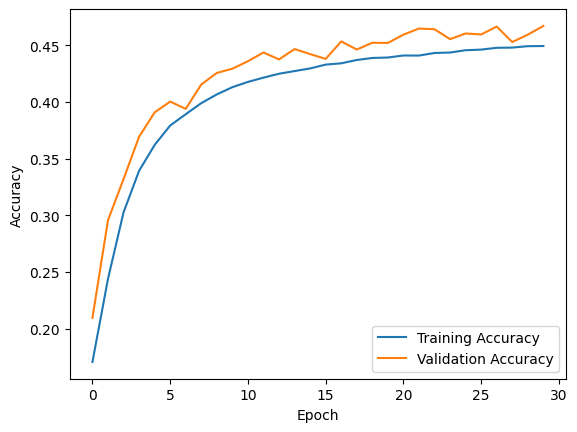

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy to epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

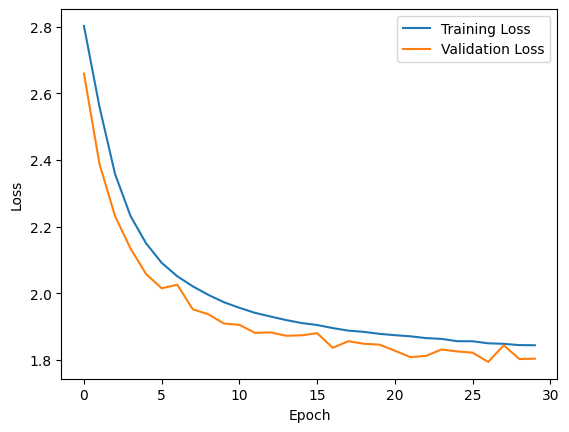

In [13]:
# Plot loss to epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# **Predicting Characters**

In [14]:
# Number of characters being predicted
num_predictions = 10

# Select a random starting point
start_index = np.random.randint(0, len(text) - sequence_length - num_predictions)

# Extract a 40-character sequence
input_sequence = text[start_index : start_index + sequence_length]

# Prepare input for prediction
input_sequence_indices = [char_to_index[char] for char in input_sequence]
input_sequence_array = np.reshape(input_sequence_indices, (1, sequence_length, 1))

# Normalize the data to values between 0 and 1
input_sequence_array = input_sequence_array / float(len(unique_characters))

# Generate predictions
predicted_sequence_indices = []
for _ in range(num_predictions):
    predictions = model.predict(input_sequence_array, verbose=0)[0]
    predicted_index = np.argmax(predictions)
    predicted_char = index_to_char[predicted_index]
    
    # Append the predicted character to the sequence
    predicted_sequence_indices.append(predicted_index)
    input_sequence_indices.append(predicted_index)
    input_sequence_indices = input_sequence_indices[1:]
    
    # Prepare the input for the next prediction
    input_sequence_array = np.reshape(input_sequence_indices, (1, sequence_length, 1))
    
    # Normalize the data to values between 0 and 1
    input_sequence_array = input_sequence_array / float(len(unique_characters))

# Convert predicted indices back to characters
predicted_sequence = ''.join([index_to_char[index] for index in predicted_sequence_indices])

# Print the result
print("Original Sequence:", input_sequence)
print("Predicted Sequence:", predicted_sequence)

Original Sequence: ires injure himself hence evil done unwi
Predicted Sequence: ld sels se


# **Model 2**

In [15]:
# Create the second model
model2 = Sequential()
model2.add(LSTM(num_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(num_neurons, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(num_neurons, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(Dense(len(unique_characters), activation='softmax'))

# Set initial weights
initial_weights = 0.05
for layer in model2.layers:
    for weight in layer.get_weights():
        weight[:] = initial_weights

# Compile the second model with RMSProp
optimizer = RMSprop(learning_rate=0.01)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the second model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 40, 128)           66560     
                                                                 
 dropout_1 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 40, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 38)               

In [16]:
# Train the model
history = model2.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/50
1868/1868 [==============================] - 490s 260ms/step - loss: 2.8372 - accuracy: 0.1632 - val_loss: 2.6598 - val_accuracy: 0.2053
Epoch 2/50
1868/1868 [==============================] - 485s 260ms/step - loss: 2.5344 - accuracy: 0.2471 - val_loss: 2.3172 - val_accuracy: 0.2995
Epoch 3/50
1868/1868 [==============================] - 487s 261ms/step - loss: 2.3192 - accuracy: 0.3056 - val_loss: 2.1552 - val_accuracy: 0.3461
Epoch 4/50
1868/1868 [==============================] - 490s 262ms/step - loss: 2.1597 - accuracy: 0.3495 - val_loss: 2.1034 - val_accuracy: 0.3623
Epoch 5/50
1868/1868 [==============================] - 490s 263ms/step - loss: 2.0445 - accuracy: 0.3820 - val_loss: 1.9023 - val_accuracy: 0.4155
Epoch 6/50
1868/1868 [==============================] - 492s 264ms/step - loss: 1.9554 - accuracy: 0.4079 - val_loss: 1.8154 - val_accuracy: 0.4364
Epoch 7/50
1868/1868 [==============================] - 490s 262ms/step - loss: 1.8975 - accuracy: 0.4238 - val_

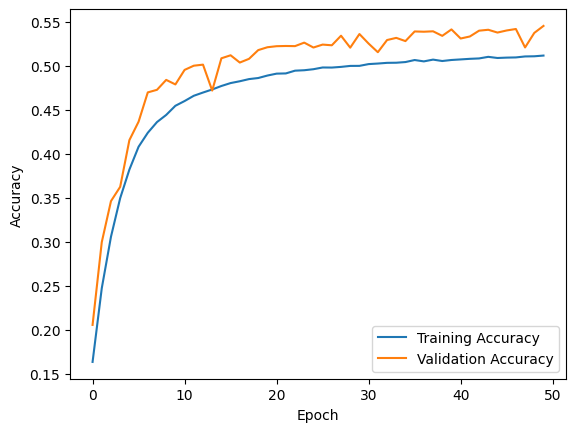

In [17]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy to epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

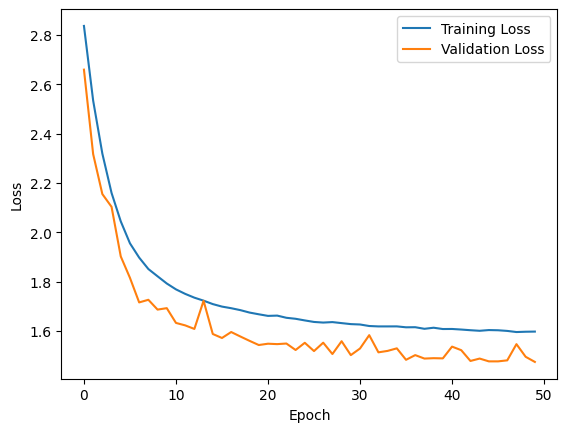

In [18]:
# Plot loss to epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [19]:
# Number of characters being predicted
num_predictions = 10

# Select a random starting point
start_index = np.random.randint(0, len(text) - sequence_length - num_predictions)

# Extract a 40-character sequence
input_sequence = text[start_index : start_index + sequence_length]

# Prepare input for prediction
input_sequence_indices = [char_to_index[char] for char in input_sequence]
input_sequence_array = np.reshape(input_sequence_indices, (1, sequence_length, 1))

# Normalize the data to values between 0 and 1
input_sequence_array = input_sequence_array / float(len(unique_characters))

# Generate predictions
predicted_sequence_indices = []
for _ in range(num_predictions):
    predictions = model2.predict(input_sequence_array, verbose=0)[0]
    predicted_index = np.argmax(predictions)
    predicted_char = index_to_char[predicted_index]
    
    # Append the predicted character to the sequence
    predicted_sequence_indices.append(predicted_index)
    input_sequence_indices.append(predicted_index)
    input_sequence_indices = input_sequence_indices[1:]
    
    # Prepare the input for the next prediction
    input_sequence_array = np.reshape(input_sequence_indices, (1, sequence_length, 1))
    
    # Normalize the data to values between 0 and 1
    input_sequence_array = input_sequence_array / float(len(unique_characters))

# Convert predicted indices back to characters
predicted_sequence = ''.join([index_to_char[index] for index in predicted_sequence_indices])

# Print the result
print("Original Sequence:", input_sequence)
print("Predicted Sequence:", predicted_sequence)

Original Sequence: e greatest strength philosopher ever exp
Predicted Sequence: eption see
